# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [82]:
import importlib
import os

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        import subprocess
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package_name])
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} has been installed.")

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"
DATA_PATH = PATH + "data/" 

os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

We import the dataset from Kaggle, using a token.

In [83]:
import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH, quiet=False)

kaggle is already installed.


  8%|▊         | 39.0M/474M [00:18<03:26, 2.21MB/s]


KeyboardInterrupt: 

In [ ]:
import zipfile
from tqdm import tqdm

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting images from zipped folder", total=len(zip_ref.infolist())):
        zip_ref.extract(file_info, PATH + FOLDERNAME)

os.remove(PATH + FOLDERNAME +".zip")

Extracting images from zipped folder:   0%|          | 0/5917 [00:00<?, ?it/s]

Extracting images from zipped folder: 100%|██████████| 5917/5917 [00:15<00:00, 390.83it/s]


If already present we import, or otherwise we install, the `tensorflow` package. Above all functionalities we will be using the `keras` module to construct neural networks to distinguish the images in the dataset.

In [ ]:
import_or_install("tensorflow","tf")
from tensorflow import keras

c:\Users\lucia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tensorflow is already installed.


# Data pre-processing

Before proceeding we remove badly encoded images from the dataset.

In [ ]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  
                img.verify()
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We have assumed that the order of the samples in the dataset was arbitrary. So, we have relied on the subdivision provided by Kaggle into training and test set, with $\frac{1}{5}$ of the images assigned to the test set. We have chosen to further partition the training set into an actual training set and a validation set, used to tune the hyperparameters for the proposed hypermodels. So, we have partitioned the images in three groups as follows:
<div style="margin-left: auto;
            margin-right: auto;
            width: 30%">

|Subset     | \% of samples |
|-----------|--------------:|
|Training   | 70            |
|Validation | 10            |
|Test       | 20            |

</div>

In [ ]:
train_ds_path = os.path.join(PATH, FOLDERNAME, "train")
test_ds_path = os.path.join(PATH, FOLDERNAME, "test")

train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    train_ds_path,
    labels='inferred',
    validation_split=0.08,
    subset="both",
    seed = 42
)

test_ds = keras.preprocessing.image_dataset_from_directory(test_ds_path, labels = "inferred")

Found 4733 files belonging to 2 classes.
Using 4355 files for training.
Using 378 files for validation.
Found 1184 files belonging to 2 classes.


Let's give a look at a small sample of pictures with the respective labels.

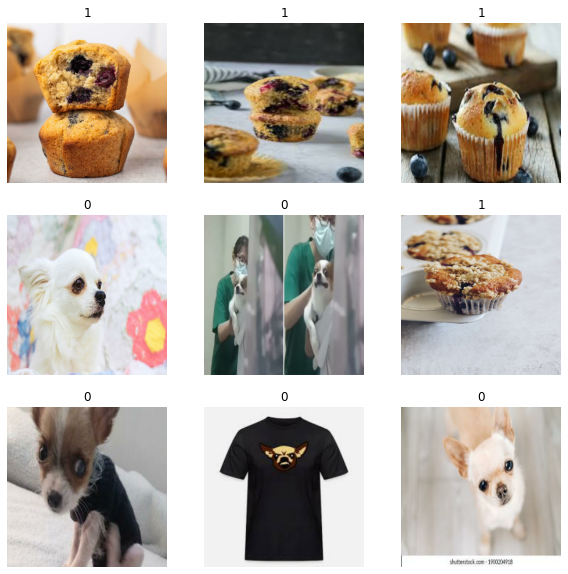

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

We also prepare a function to convert a `tensorflow.Dataset` object into a dataset in numpy array form, to make the order of the samples fixed.

In [ ]:
def dataset_to_numpy_arrays(dataset):   
    dataset = dataset.unbatch()
    X = []
    y = []
    for features, labels in dataset:
        X.append(features.numpy())
        y.append(labels.numpy())
    X = np.array(X)
    y = np.array(y)
    return X,y

Before diving into the actual pre-processing of the data we prepare a function that produces realistic variations of the images in the dataset. This data augmentation step is useful to make a small dataset more expressive by introducing random changes, so counteracting overfitting.

We have chosen to apply different random alterations, listed below.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

random_augmentation_parameters = {
    'rotation_range': np.random.randint(-20, 20),
    'width_shift_range': np.random.uniform(0.0, 0.2),
    'height_shift_range': np.random.uniform(0.0, 0.2),
    'shear_range': np.random.uniform(0.0, 0.2),
    'zoom_range': np.random.uniform(0.0, 0.2),
    'horizontal_flip': np.random.choice([True, False])
}


To have a better idea of the potential results of data augmentation, we look at the modifications applied to a an example image.

Original image:


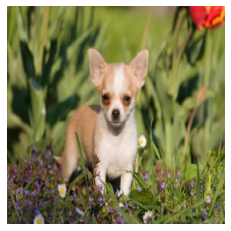

Altered images:


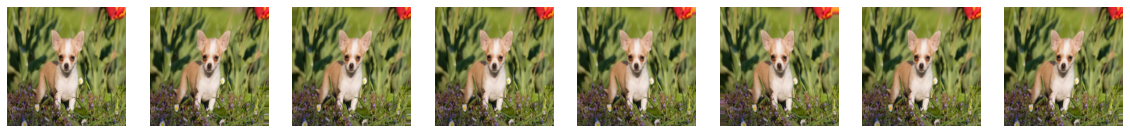

In [ ]:
pic_path = os.path.join(train_ds_path, "chihuahua", "img_0_53.jpg")
img = keras.preprocessing.image.load_img(pic_path, target_size= (500,500))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

print("Original image:")
plt.imshow(img)
plt.axis('off')
plt.show()

datagen = ImageDataGenerator(**random_augmentation_parameters)
pic = datagen.flow(img_tensor)

print("Altered images:")
plt.figure(figsize=(20,15))

for i in range(1,9):
  plt.subplot(1, 8, i)
  batch = pic.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)
  plt.axis('off')
plt.show()

To make learning easer we simplify the images by:
* taking them in grayscale,
* reducing their dimensions by resizing them to the size $(64,64)$.

In [ ]:
def rgb_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

def resize_image(image, target_size):
    resized_image = tf.image.resize(image, target_size)
    return resized_image


image_size = (64,64)

preprocess = {
    'rgb_to_grayscale': lambda x, y: (rgb_to_grayscale(x),y),
    'resize_image': lambda x,y: (resize_image(x, image_size),y)
}

for func_name, func in preprocess.items():
    train_ds = train_ds.map(func)
    val_ds = val_ds.map(func)
    test_ds = test_ds.map(func)

# Model construction

To try and classify the images in the dataset we build various neural network models, defined by the respective classes. For the moment we prepare the structure of each neural network, and other parameters, like `optimizer`, `loss` and `metrics`, that will be needed to compile the models.

Also, instead of fixing the values that characterize the layers of the models, we have used hyperparameters placeholders. We have opted to define the hypermodels as subclasses of the `keras_tuner.Hypermodel` type, that in the building phase depends on a `HyperParameter` object, that allows to specify the type and domain for the desired hyperparameters. These will be tuned in a later step.

In the next sections we display the classes for each of the hypermodels, and we give a visual representation of the sequential layers.

In [ ]:
%%capture
from keras import layers

input_shape = train_ds.element_spec[0].shape[1:]

import_or_install("pydot")
def display_hypermodel(hypermodel_class, hypermodel_name):
    hypermodel = hypermodel_class(input_shape)
    built_hypermodel = hypermodel.build(kt.HyperParameters())
    return keras.utils.plot_model(built_hypermodel, show_layer_names=True)

In [ ]:
import_or_install("keras_tuner","kt")

keras_tuner is already installed.


## Hypermodels

### Hypermodel 1

In [ ]:
class HyperModel_1(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

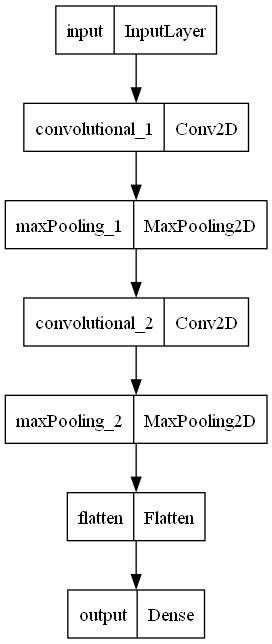

In [ ]:
display_hypermodel(HyperModel_1, 'hypermodel_1')

The first, simpler model, is composed by two convolutional layers, ideal for detecting patterns in images. Also, each of the convolutional layers is followed by a max pooling layer, with the aim of summarizing the information extracted by passing multiple kernels over the images a number of times corresponding to the `filters` hyperparameter.

After the first learning stage follows a flattening layer, that reduces the expressivity of the foundings, and also simplifies the task left for the next step. Finally, the last output layer is designed to summarize this information into a unique value in the interval $\left[0,1\right]$.

### Hypermodel 2

In [ ]:
class HyperModel_2(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

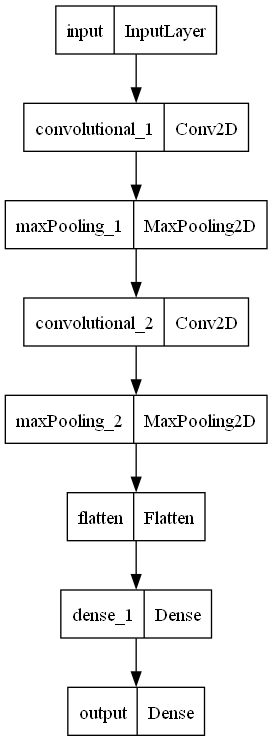

In [ ]:
display_hypermodel(HyperModel_2,'hypermodel_2')

We have experimented by adding a dense layer as the last step in the network, to see if a reinterpretation of the information extract by the convolutional layers would help detect the class better.

### Hypermodel 3

In [ ]:
class HyperModel_3(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [ ]:
display_hypermodel(HyperModel_3, 'hypermodel_3')

For this model we wanted to study the quality of the prediction obtained by adding an additional convolutional layer and max pooling layer. The idea is that this network should be able to detect mode complex patterns in the images.

To assure that all possible combinations of hyperparameters would be valid, we have chosen to add pad the images during the convolutional stages. Seen that the stride is set to $(1,1)$, the dimension of the images as input and output of a convolutional layer a unchanged.

### Hypermodel 4

In [ ]:
class HyperModel_4(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

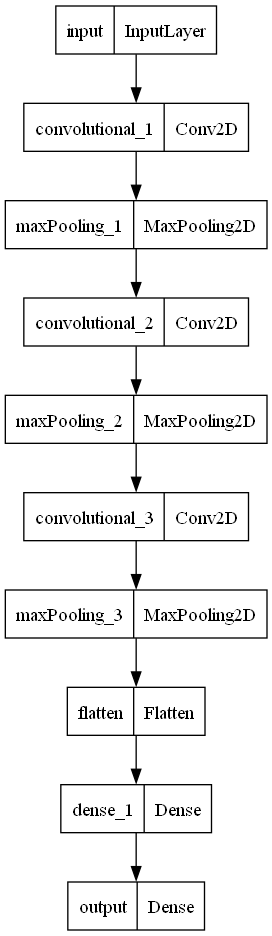

In [ ]:
display_hypermodel(HyperModel_4, 'hypermodel_4')

Lastly, we were curious to see the both the additions to the first hypermodel applied together.

In [ ]:
hypermodels = {
    'hypermodel_1': HyperModel_1,
    'hypermodel_2': HyperModel_2,
    'hypermodel_3': HyperModel_3,
    'hypermodel_4': HyperModel_4
}

## Hyperparameter tuning

Now that we have outlined the structure of the neural networks we choose the hyperparameters for each layer. Specifically we are looking to set a value for the following parameters:
* convolutional layers (type `Conv2D`)
    * number of filters
    * size of the kernels, square in shape
* max pooling layers (type `MaxPooling2D`)
    * size of the pool
* dense layers that are no output layers (type `Dense`)
    * number of nodes
    
To do this we use the `keras_tuner` library {cite}`omalley2019kerastuner`, that allows hyperparameter tuning. It allows to build a `Tuner` object based on a compiled Keras model that has as argument a `Hyperparameter` object. Such a tuner can then search for the best possible hyperparameters for the model and value domains that have been supplied. 

For efficiency reasons we have opted for a random search in the hyperparameter space, in fact we have set the `max_trials` option such that only a portion of the combinations of hyperparameters will be evaluated.   
The tuner also acts as a log for the hyperparameter combinations that have been tested.

In [ ]:
def tune_hypermodel(model_name, model_class, train_ds, val_ds, directory, max_trials):
    tuner = kt.RandomSearch(
        model_class(input_shape),
        objective = 'val_loss',
        directory = directory,
        max_trials = max_trials,
        project_name = model_name)

    tuner.search(train_ds, epochs = 10, validation_data = val_ds)

    return tuner

In the following sections we tune the hyperparameters for all four of the hypermodels. The possible models are fitted against the training set, and their quality is measured with respect to the binary cross-entropy loss computed for the validation set.

We first prepare a few functions that will be useful to extract the best hyperparameters chosen by the tuners, and to look at the losses  for the models built by choosing the best hyperparameters.

In [ ]:
import_or_install("pandas","pd")

def tuners_get_best_hyperparameters(tuners, hypermodels):
    best_hps = {}
    for hypermodel_name in hypermodels:
        best_hps[hypermodel_name] = tuners[hypermodel_name].get_best_hyperparameters()[0]
    return best_hps   
        
def tuners_display_best_hyperparameters(tuners, hypermodels):
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    best_hps_values = {k: v.values for k, v in best_hps.items()}
    print(pd.DataFrame.from_dict(best_hps_values).fillna("-"))
    
def tuners_display_metrics(tuners, hypermodels):
    best_metrics = {}
    for hypermodel_name in hypermodels:
        best_metrics[hypermodel_name] = tuners[hypermodel_name].oracle.get_best_trials(1)[0].score
    print(pd.DataFrame({ k:[v] for (k,v) in best_metrics.items()}, index = ["loss"]))

pandas is already installed.


### Without data augmentation

We have initially tuned the hyperparameters by using the original training and validation sets, by looking at 300 possible combinations of the hyperparameter values chosen randomly.

If present, the tuners are reloaded from the *tuners* directory in the folder dedicated to storing the data for this project.

In [ ]:
tuners = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/GPU:0'):
        tuners[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_ds, val_ds, DATA_PATH +'tuners', 300)

Reloading Tuner from ./data/tuners\hypermodel_1\tuner0.json


Reloading Tuner from ./data/tuners\hypermodel_2\tuner0.json
Reloading Tuner from ./data/tuners\hypermodel_3\tuner0.json
Reloading Tuner from ./data/tuners\hypermodel_4\tuner0.json


### With data augmentation

As we anticipated when discussing [data pre-processing](#data-pre-processing), we have used data augmentation to make the training set more expressive to avoid overfitting. Specifically, we have chosen to apply a random transformation to the images in the training set before each epoch of the fitting process.

If present, the tuners are reloaded from the *tuners_augmented* directory in the folder dedicated to storing the data for this project.

In [ ]:
train_generator = datagen.flow(dataset_to_numpy_arrays(train_ds))
tuners_augmented = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/GPU:0'):
        tuners_augmented[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_generator, val_ds, DATA_PATH + 'tuners_augmented', 300)
    

Reloading Tuner from ./data/tuners_augmented\hypermodel_1\tuner0.json
Reloading Tuner from ./data/tuners_augmented\hypermodel_2\tuner0.json
Reloading Tuner from ./data/tuners_augmented\hypermodel_3\tuner0.json
Reloading Tuner from ./data/tuners_augmented\hypermodel_4\tuner0.json


### Resulting best models

Now that we have found a collection of good hyperparameters, we build the resulting models, that will serve for evaluating of the quality of the models. We do this for the hyperparameters extracted by using the original training set and the augmented version.

In [ ]:
def get_best_models(tuners, hypermodels):
    best_model = {}
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    for hypermodel_name, hypermodel_class in hypermodels.items():
        hps = best_hps[hypermodel_name]
        model = hypermodel_class(input_shape)
        best_model[hypermodel_name[5:]] = model.build(hps)
    return best_model

In [ ]:
best_models = get_best_models(tuners, hypermodels)
best_models_augmented = get_best_models(tuners_augmented, hypermodels)

# Evaluation

We will evaluate the various neural networks according to their risk with zero-one loss. We will estimate such measure using $5$-fold cross validation.

Here we prepare the functions that we will use to perform the cross validation. We have chosen to round the predicted labels in $\left[0,1\right]$ to the nearest digit.

In [ ]:
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping


def fold_validation(model, X, y, train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit model on training portion of the fold
    print("\nFitting model to train portion")
    callback = EarlyStopping(monitor='val_loss', patience=3)
    model.fit(X_train, y_train, epochs = 100, batch_size = 16, callbacks = [callback])
    
    #Predict labels for the test portion of the fold
    print("\nPredicting labels for test portion")
    predicted_labels_continuous = model.predict(X_test)
    predicted_labels = [round(l[0]) for l in predicted_labels_continuous]
    loss = zero_one_loss(y_test, predicted_labels)
    return loss

def cross_validation(model, model_name, X, y, num_folds):
    kf = KFold(n_splits=num_folds)
    
    losses = [0]*num_folds
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold: {i+1}")
        model.load_weights(f"{DATA_PATH}/{model_name}.h5")
        losses[i] = fold_validation(model, X, y, train_index, test_index)
        
    return losses
      

We also log the risks estimated by the cross validation process to archive computations executed beforehand. At this scope we define a class `LossesJson` that allows to maintain and modify a json array, also saved in a dedicated file in the directory dedicated to data.

In [ ]:
import json
from os.path import exists

class LossesJson:
    def __init__(self, filename):
        self.filename = filename
        if not exists(filename):
            with open(filename, 'w') as file:
                json.dump({}, file, indent = 4)
        self.load()
        
    def __str__(self):        
        aesthetic_dict = {
            model: {
                    **model_data["loss_folds"],
                    "loss_cv": model_data["loss_cv"]
                }
            for model, model_data in self.losses.items()
        }
        return str(pd.DataFrame.from_dict(aesthetic_dict))
    

    def update(self, model_name, losses):
        def losses_to_dict(loss_cv, loss_folds):
            losses_dict = {}
            num_folds = len(loss_folds)
            losses_dict["loss_folds"] = {}
            for fold in range(num_folds):
                fold_name =  f"fold_{fold+1}"
                losses_dict["loss_folds"][fold_name] = loss_folds[fold]
            losses_dict["loss_cv"] = loss_cv
            return losses_dict
        
        self.losses[model_name] = losses_to_dict(np.mean(losses), losses)
        self.save()

    def save(self):
        with open(self.filename, 'w') as file:
            json.dump(self.losses, file, indent = 4)

    def load(self):
        with open(self.filename, 'r') as file:
            self.losses = json.load(file)
            
    def get_losses(self):
        self.load()
        return self.losses


We prepare a utility function that we will use to execute cross validation and save its progress. If a file in json form is already located in the present directory, it's content will be loaded to access the possible precomputed losses for some of the models, with respect to the provided dataset during computation.

In [ ]:
from multiprocessing import Pool

def save_execute_cross_validation_on_models(filename, models, X,y, num_folds):
    
    # Initialize LossesJson object
    losses_json = LossesJson(filename)
    
    # Load losses from filename.json
    if exists(filename):
        print(f"Loading losses from {filename} for models: ")
    
    # Get models for which there are no precomputed losses
    models_without_losses = dict(models)
    for key in losses_json.get_losses():
        print(f"{key} ")
        models_without_losses.pop(key)
    
    # Execute cross validation on models without precomputed losses
    if len(models_without_losses):        
        for model_name, model_class in models_without_losses.items():
            print(f"### Cross_validation for model: {model_name} ###")
            model_class.save_weights(f"{DATA_PATH}/{model_name}.h5")
            losses = cross_validation(model_class, model_name, X,y, num_folds)
            print(f"### Cross_validation results for model: {model_name} ###")
            print(f"Losses: {losses}")
            print(f"Cross validation loss: {np.mean(losses)}")
            losses_json.update(model_name, losses)
    
    return losses_json

The approximated risk values shown below are a reference to discuss the best performing hypermodel, and the choice of training method. In all cases the models are tested on the test set provided by Kaggle.

### Original dataset

We first look at the risk approximation for the best model we have found by using cross validation on the original Kaggle dataset.

#### Without data augmentation

In the first case we evaluate the best models obtained by setting the best hyperparameters chosen based on the training and validation set.

In [ ]:
dataset = train_ds.concatenate(val_ds).concatenate(test_ds)
X,y = dataset_to_numpy_arrays(dataset)

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models = save_execute_cross_validation_on_models(DATA_PATH + "losses.json", best_models, X, y, 5)


Loading losses from ./data/losses.json for models: 
model_1 
model_2 
model_3 
model_4 


In [ ]:
print(losses_json_best_models)

          model_1   model_2   model_3   model_4
fold_1   0.173986  0.159628  0.159628  0.157095
fold_2   0.184122  0.165541  0.179899  0.441723
fold_3   0.177515  0.171598  0.166526  0.461538
fold_4   0.183432  0.198648  0.191040  0.165680
fold_5   0.158073  0.158918  0.202029  0.155537
loss_cv  0.175426  0.170866  0.179824  0.276315


### With data augmentation

We also look at the results for the models obtained by choosing the hyperparameters that allow the augmented training set to fit best.

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_augmented = save_execute_cross_validation_on_models(DATA_PATH + "losses_augmented.json",  best_models_augmented, X, y, 5)


Loading losses from ./data/losses_augmented.json for models: 
model_1 
model_2 
model_3 
model_4 


In [ ]:
print(losses_json_best_models_augmented)

          model_1   model_2   model_3   model_4
fold_1   0.122466  0.217905  0.461993  0.081081
fold_2   0.096284  0.219595  0.440034  0.040541
fold_3   0.125951  0.461538  0.461538  0.027895
fold_4   0.076923  0.212172  0.473373  0.037194
fold_5   0.173288  0.201183  0.459848  0.181741
loss_cv  0.118982  0.262479  0.459357  0.073690


### Dataset without validation

We have also decided to study the quality of the models by not including the validation set in the dataset used for cross validation. In fact, the validation set has been used to determine the hyperparameters, so we expect these images to be classified better by the chosen models.

Also in this case we look at the results for the best models obtained by choosing the hyperparameters on the basis of the original training set, and on the augmented version.

#### Without data augmentation

In [ ]:
dataset = train_ds.concatenate(test_ds)
X,y = dataset_to_numpy_arrays(dataset)

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_without_validation = save_execute_cross_validation_on_models(DATA_PATH + "losses_without_validation.json", best_models, X, y, 5)

Loading losses from ./data/losses_without_validation.json for models: 
model_1 
model_2 
model_3 
model_4 


In [ ]:
print(losses_json_best_models_without_validation)

          model_1   model_2   model_3   model_4
fold_1   0.214801  0.193141  0.169675  0.156137
fold_2   0.188628  0.175090  0.187726  0.189531
fold_3   0.208484  0.195848  0.196751  0.163357
fold_4   0.165162  0.175993  0.164260  0.179603
fold_5   0.186089  0.160795  0.176152  0.192412
loss_cv  0.192633  0.180173  0.178913  0.176208


#### With data augmentation

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_augmented_without_validation = save_execute_cross_validation_on_models(DATA_PATH + "losses_augmented_without_validation.json", best_models, X, y, 5)

Loading losses from ./data/losses_augmented_without_validation.json for models: 
model_1 
model_2 
model_3 
model_4 


In [ ]:
print(losses_json_best_models_augmented_without_validation)

          model_1   model_2   model_3   model_4
fold_1   0.067690  0.080325  0.094765  0.093863
fold_2   0.082130  0.100181  0.118231  0.088448
fold_3   0.083935  0.071300  0.101083  0.082130
fold_4   0.098375  0.076715  0.073105  0.074007
fold_5   0.160795  0.202349  0.205962  0.250226
loss_cv  0.098585  0.106174  0.118629  0.117735
